# Credit-Line | EDA

- [Дата и время](#Дата-и-время)
- [Анализ пропусков](#Анализ-пропусков)
- [Корреляция](#Корреляция)
- [Выгрузка датасета](#Выгрузка-датасета)

TODO:
- обработка mail_domain
- придумать обработку position и fullname

In [7]:
import re
import sys
sys.path.append('..')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
import nltk
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import utils

import phik
from phik.report import plot_correlation_matrix
from phik import report

import os

In [76]:
DATA_PATH = os.path.join('..', 'data', 'raw', 'raw.csv')

In [77]:
data = pd.read_csv(
    DATA_PATH,
    index_col='AppId',
    parse_dates=[
        'dtstart',
        'birthday'
    ],
)

In [78]:
data = data.drop(columns=[
    
    # targets
    # '30_2mob',
    '30_3mob',
    '90_6mob',
    '90_12mob',

    # data leak
    'sigdoc',
    'verification',
    'EmployeeId',
    
    # поля-разделители
    'Сервис3',
    'risk',
    'Comment',
    'clientid',
    'ds_ver',

    # origin
    'nation',  # полностью повторияет `citizenshipid`
    'spouseincome',  # константный признак
    'amountoriginal',  # полностью повторияет `Loan amount`
    'client_type',  # константный признак
    'educationid',  # константный признак
    'bankrupt',  # константный признак
    'monthlycreditpayment',  # константный признак
    "AmountPurchaseOriginal", # повторяет Loan amount
    "idchannel", # неинформативное
    "CustomerReg", # нет информации о том, что это за поле
    'CategoryGoodsId', # коррелирует с sitename
    'positionlevel', # corr EmployementType
    'pref_mobile', 
    'domen', # коррелирует с sitename
    'risk_cat', # corr with sitename
    'CompanyTypeId', # коррелирует с sitename
    'othercredits', # коррелирует с sitename
    'creditperiod',
    # 'nameto', # corr with sitename
    
    # NBKI
    'Timestamp',  # Есть старые запросы до года, однако их очень мало. В основном запросы не старше суток
    'Recent_account_date',  # Всего 743 non-null
    'Oldest_account_date',  # Всего 743 non-null
    'Total_disputed',  # константный признак
    'Total_letigation',  # константный признак
    'Total_bankruptcy',  # константный признак
    'RCC_overdue_amount',  # константный признак
    'Fico_score',  # не можем получать
    'Reg_region', # неинформативный признак
    'Liv_region', # неинформативный признак
    'Is_FICO', # больше не получаем
    'CH_length', # мало записей
    'Nb_active_rcc', # почти константная фича
    'Nb_active_consumer_credit', # почти константная фича

    # Equifax
    'Timestamp_eq',  # Есть старые запросы до года, однако их очень мало. В основном запросы не старше суток
    'Recent_account_date_eq',  # Всего 2060 non-null
    'Oldest_account_date_eq',  # Всего 2060 non-null
#     'Payment_cards',  # константный признак
#     'Total_bankruptcy_eq',  # константный признак
#     'Total_letigation_eq',  # константный признак
#     'RCC_credit_limit_eq',  # константный признак
#     'RCC_overdue_amount_eq',  # константный признакы
#     "current_120DPD_3K_flag",
#     "Nb_active_consumer_credit_eq",
#     "Nb_active_rcc_eq",
#     "Nb_active_mortgages_eq",
])

data = data.query('dtstart < "2023-08-01"')

data['60_6mob'] = data['60_6mob'].apply(lambda x: 0 if str(x) == '0.0' else 1)  # Предобработка таргета
data['30_2mob'] = data['30_2mob'].apply(lambda x: 0 if str(x) == '0.0' else 1)  # Предобработка таргета

data.head()

,dtstart,InitialFee,sex,birthday,citizenshipid,martialid,dependents,typeemployerid,nameto,sitename,DOC,averagemonthlyincome,fullname,position,OccupationAreaId,EmploymentType,Total_accounts,Total_negative_accounts,Total_active_accounts,Total_credit_limit,Total_overdue_amount,Total_outstanding_amount,Total_installment_amount,Total_installment_amount_calc,Total_disputed,Total_letigation,Total_bankruptcy,Total_inquiries,Recent_inquiries,CH_length,Nb_delays_5_30_ever,Nb_delays_30_60_ever,Nb_delays_60_90_ever,Nb_delays_90_ever,Nb_delays_5_30_2y,Nb_delays_30_60_2y,Nb_delays_60_90_2y,Nb_delays_90_2y,Days_since_last_credit,Own_active_accounts_nb,Max_overdue,RCC_credit_limit,RCC_overdue_amount,Nb_active_mortgages,Nb_active_microcredits,Total_mortgages,Total_microcredits,Nb_active_consumer_credit,Nb_active_rcc,Total_consumer_credit,Total_rcc,scoreRetailPersonal,Total_accounts_ever,Total_active_accounts_eq,Total_credit_limit_active_eq,Total_outstanding_amount_eq,Total_overdue_amount_eq,Total_pay_amount,Total_pay_amount_non_card,Payment_cards,Total_bankruptcy_eq,Total_letigation_eq,current_120DPD_3K_flag,Nb_delays_5_30_ever_eq,Nb_delays_30_60_ever_eq,Nb_delays_60_90_ever_eq,Nb_delays_90plus_ever_eq,Nb_delays_5_30_2y_eq,Nb_delays_30_60_2y_eq,Nb_delays_60_90_2y_eq,Nb_delays_90plus_2y_eq,Max_overdue_eq,RCC_credit_limit_eq,RCC_overdue_amount_eq,Nb_active_consumer_credit_eq,Nb_active_rcc_eq,Nb_active_mortgages_eq,Nb_microcredits_ever,CH_length_eq,Nb_active_microcredits_eq,S_hare_active_credit,S_hare_micro,StatusCodeResponse,Score,MatchingLevel,ALLCLCValueId,BLOCKCNTValueId,BLOCKDURValueId,INTEGRALSCOREValueId,LIFETIMEBINValueId,PAYMAXValueId,loan_amount,30_2mob,60_6mob
AppId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
888776,2020-03-20 17:53:00,4718.0,1.0,1977-10-24,417,2.0,1,3,ПАО Вымпел-Коммуникации,www.beeline.ru,NaN,40000,"ООО ""Левел МСК""",ПОВАР,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,0.0,0.087179,5.0,4.0,18872.0,0,0
890354,2020-03-21 00:00:00,5117.8,2.0,1990-10-24,417,5.0,0,3,ПАО Вымпел-Коммуникации,www.beeline.ru,NaN,40000,АЭРОПОРТ ШЕРЕМЕТЬЕВО колбасный цех,ПОВАР,NaN,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,1.0,0.247514,5.0,3.0,20471.2,0,0
890401,2020-03-21 17:55:00,3282.0,2.0,1990-08-27,417,2.0,2,3,ООО Заря,www.maximus.ru,NaN,42000,ООО ТК ДОБРОНОМ,ПРОДАВЕЦ-КАССИР,12.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,4.0,0.157701,4.0,3.0,13128.0,1,1
890489,2020-03-21 19:00:00,3629.8,1.0,1995-08-29,417,1.0,0,3,ПАО Вымпел-Коммуникации,www.beeline.ru,NaN,60000,Элион европейский,ПОВАР,NaN,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,4.0,0.209901,2.0,4.0,14519.2,0,0
891426,2020-03-22 13:36:00,5375.6,2.0,1982-06-02,417,2.0,2,3,ООО Заря,www.maximus.ru,NaN,40000,ООО ЕВРОСПАР,ПОВАР,15.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [79]:
data['sex'] = data['sex'].replace(1002.0, np.nan)

data['age'] = (data['dtstart'] - data['birthday']) / np.timedelta64(1, 'Y')
data = data.drop(columns='birthday')
data['month'] = data['dtstart'].dt.month
data['day'] = data['dtstart'].dt.day
data['weekday'] = data['dtstart'].dt.weekday
data['seconds'] = pd.to_timedelta(data['dtstart'].dt.time.astype(str)).dt.total_seconds()
data['year'] = data['dtstart'].dt.year

# data['fullname'] = data['fullname'].fillna('пропуск')
# data['fullname'] = data['fullname'].apply(foo_fullname)
# data = group_other(data, 'fullname', 100)
# data['phone_prefix'] = data['phone_prefix'].apply(foo_phone_prefix)

In [43]:
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 24350 entries, 888776 to 1912560
Data columns (total 107 columns):
 #    Column                         Non-Null Count  Dtype         
---   ------                         --------------  -----         
 0    dtstart                        24350 non-null  datetime64[ns]
 1    CategoryGoodsId                24350 non-null  int64         
 2    InitialFee                     24350 non-null  float64       
 3    sex                            24187 non-null  float64       
 4    citizenshipid                  24350 non-null  int64         
 5    domen                          14500 non-null  object        
 6    pref_mobile                    24347 non-null  float64       
 7    martialid                      24342 non-null  float64       
 8    dependents                     24350 non-null  int64         
 9    typeemployerid                 24350 non-null  int64         
 10   nameto                         24350 non-null  object        
 11 

In [17]:
data['risk_cat'].value_counts()

risk_cat
Very High    23514
Normal         773
High            50
Very Low         8
NORMAL           5
Name: count, dtype: int64

In [22]:
data['scoreRetailPersonal'].value_counts()

scoreRetailPersonal
133.0    4
110.0    3
136.0    3
131.0    3
184.0    3
        ..
640.0    1
913.0    1
170.0    1
242.0    1
111.0    1
Name: count, Length: 139, dtype: int64

## Preprocessing

In [38]:
import nltk
nltk.download("stopwords")
stopwords = nltk.corpus.stopwords.words("russian")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Muminsho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
data.position.value_counts()

position
 ВОДИТЕЛЬ            707
 СТРОИТЕЛЬ           682
ПОВАР                648
 ПОВАР               639
ВОДИТЕЛЬ             504
                    ... 
АВТОПОГРУЗЧИК          1
СБОРЩИК-МОНТАЖНИК      1
СТЮАРД                 1
эксковаторщик          1
 Шафёр                 1
Name: count, Length: 3058, dtype: int64

In [130]:
def foo_position(x):
    x = str(x).strip().lower()

    x = re.sub("\W+", " ", x)
    x = re.sub("\d+", "", x)

    if 'рабочий' in x or 'робоч' in x:
        x = 'рабочий'
    elif 'такси' in x:
        x = 'таксист'
    elif 'кассир' in x:
        x = 'кассир'
    elif 'строитель' in x:
        x = 'строитель'
    elif 'курьер' in x or 'доставщик' in x:
        x = 'курьер'
    elif 'маляр' in x or 'молер' in x or 'моляр' in x:
        x = 'маляр'
    elif 'продавец' in x:
        x = 'продавец'
    elif 'водитель' in x  or 'водит' in x:
        x = 'водитель'
    elif 'повар' in x or 'пекарь' in x:
        x = 'повар'
    elif 'уборщик' in x or 'уборщица' in x or 'уборк' in x:
        x = 'уборщик'
    elif 'грузчик' in x or 'груз' in x:
        x = 'грузчик'
    elif 'монтажник' in x:
        x = 'монтажник'
    elif 'администратор' in x:
        x = 'администратор'
    elif 'менеджер' in x:
        x = 'менеджер'
    elif 'бригадир' in x:
        x = 'бригадир'
    elif 'оператор' in x:
        x = 'оператор'
    elif 'мастер' in x:
        x = 'мастер'
    elif 'директ' in x:
        x = 'директор'
    elif 'слесарь' in x:
        x = 'слесарь'
    
    if x in ["none", "null", "nan", "", " "]:
        x = "пропуск"

    return x

In [131]:
check = pd.DataFrame(data['position'].apply(foo_position))

In [102]:
cols = [
    'начальник',
    'управляющий',
]

In [132]:
check.value_counts()[:34]

position     
повар            2159
водитель         1978
рабочий          1879
уборщик          1613
строитель        1569
курьер           1157
таксист           899
кассир            823
грузчик           819
продавец          693
дворник           647
монтажник         562
маляр             461
мастер            438
оператор          345
бригадир          336
сварщик           321
электрик          306
менеджер          288
комплектовщик     237
кладовщик         233
слесарь           224
администратор     204
сантехник         204
швея              173
мойщик            169
директор          156
плотник           150
упаковщик         145
каменщик          131
официант          117
отделочник        117
специалист        110
прораб            107
Name: count, dtype: int64

In [16]:
from sklearn.preprocessing import OrdinalEncoder

In [30]:
oenc = OrdinalEncoder(
    min_frequency = 100
).set_output(transform='pandas')

In [32]:
oenc.fit_transform(check)

,position
AppId,
2109337,19.0
2110492,32.0
2106411,22.0
2111660,33.0
2110507,33.0
...,...
2095578,33.0
2098268,6.0
2098672,33.0


In [39]:
def foo_fullname(x):
    # TODO: x = x.fillna('пропуск')
    x = str(x).strip().lower()

    x = re.sub("\W+", " ", x)  # убирает спец символы
    x = re.sub("\d+", "", x)  # убирает цифры

    x_splitted = [word for word in x.split() if word not in stopwords]
    for word in x_splitted:
        if word in ["су", "пик", "констракшн", "прайдекс", "эталон"]:
            x_splitted = ["стройка"]
            break
        elif word in ["школа"]:
            x_splitted = ["школа"]
            break
        elif word in ["университет"]:
            x_splitted = ["университет"]
            break
        elif word in ["спар"]:
            x_splitted = ["супермаркет"]
            break
        elif word in ["чайхона", "чайхана", "урюк"]:
            x_splitted = ["чайхана"]
            break
    x = " ".join(x_splitted)

    if x.startswith("ооо"):
        x = x.replace("ооо", "")
    elif x.startswith("ао"):
        x = x.replace("ао", "")
    elif x.startswith("зао"):
        x = x.replace("зао", "")
    elif x.startswith("оао"):
        x = x.replace("оао", "")
    elif x.startswith("пао"):
        x = x.replace("пао", "")
    elif x.startswith("ип"):
        x = "ип"

    if "жилищник" in x or "благоустройство" in x:
        x = "жилищник"
    elif (
        "строй" in x
        or "фодд" in x
        or "крост д" in x
        or "ант япы" in x
        or "ибт" in x
        or "анттек" in x
    ):
        x = "стройка"
    elif (
        "дикси" in x
        or "вкусвилл" in x
        or "ашан" in x
        or "пятерочка" in x
        or "магнит" in x
        or "билла" in x
        or "перекресток" in x
        or "лента" in x
        or "евроспар" in x
    ):
        x = "супермаркет"
    elif "такси" in x or "taxi" in x or "сити мобил" in x:
        x = "такси"
    elif (
        "самокат" in x
        or "деливери клаб" in x
        or "яндекс еда" in x
        or "яндекс доставка" in x
        or "яндекс лавка" in x
        or "локалкитчен" in x
        or "деливери" in x
        or "кухня районе" in x
    ):
        x = "доставка"
    elif "яндекс" in x:
        x = "яндекс"
    elif "альфа м" in x:
        x = "красное белое"
    elif "петрович" in x:
        x = "петрович"
    elif "бургер кинг" in x:
        x = "burger king"

    x = x.strip()

    if x in ["nan", " null", "none", ""]:
        x = None

    return x

In [40]:
data['fullname'].value_counts()

fullname
 ООО ЯНДЕКС.ТАКСИ               331
ООО ЯНДЕКС.ТАКСИ                214
ООО ЯНДЕКС.ЕДА                  117
 ООО ЯНДЕКС.ЕДА                 110
ООО ДЕЛИВЕРИ КЛАБ               100
                               ... 
ООО БОэс                          1
АО АЙТИ                           1
ИП Ницора Алёна Владимировна      1
 таксопар Стакс                   1
 ООО АРТИТАЙМ                     1
Name: count, Length: 17790, dtype: int64

In [45]:
c = pd.DataFrame(data['fullname'].apply(foo_fullname))

In [52]:
c.value_counts().head(40)

fullname             
стройка                  2377
ип                       1516
такси                     933
жилищник                  886
доставка                  722
супермаркет               669
яндекс                    216
красное белое             136
чайхана                    81
школа                      72
агроторг                   60
петрович                   57
тануки                     48
burger king                45
самозанятый                42
кфс                        41
гуп мосгортранс            36
чистая линия               32
тандер                     30
университет                28
сму                        28
деловые линии              26
мавис                      26
delivery club              26
мсу                        25
шоколадница                25
рандеву                    24
суши вок                   23
вертикаль                  23
озон                       23
арни                       22
птицефабрика северная      22
эф эл си          

In [49]:
merged = pd.merge(c, check, left_index=True, right_index=True)

In [55]:
from sklearn.compose import ColumnTransformer

In [61]:
ct = ColumnTransformer(
    [
        ('ordinal_pos', OrdinalEncoder(min_frequency=100), ['position']),
        ('ordinal_full', OrdinalEncoder(min_frequency=20), ['fullname']),
    ],
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [62]:
see = ct.fit_transform(merged)

In [68]:
see['position'].nunique()

34

interval columns not set, guessing: ['position', 'fullname']


/var/folders/px/3klfkkvx3tncjgwrqb5l4jhc0000gp/T/ipykernel_4086/2500404079.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


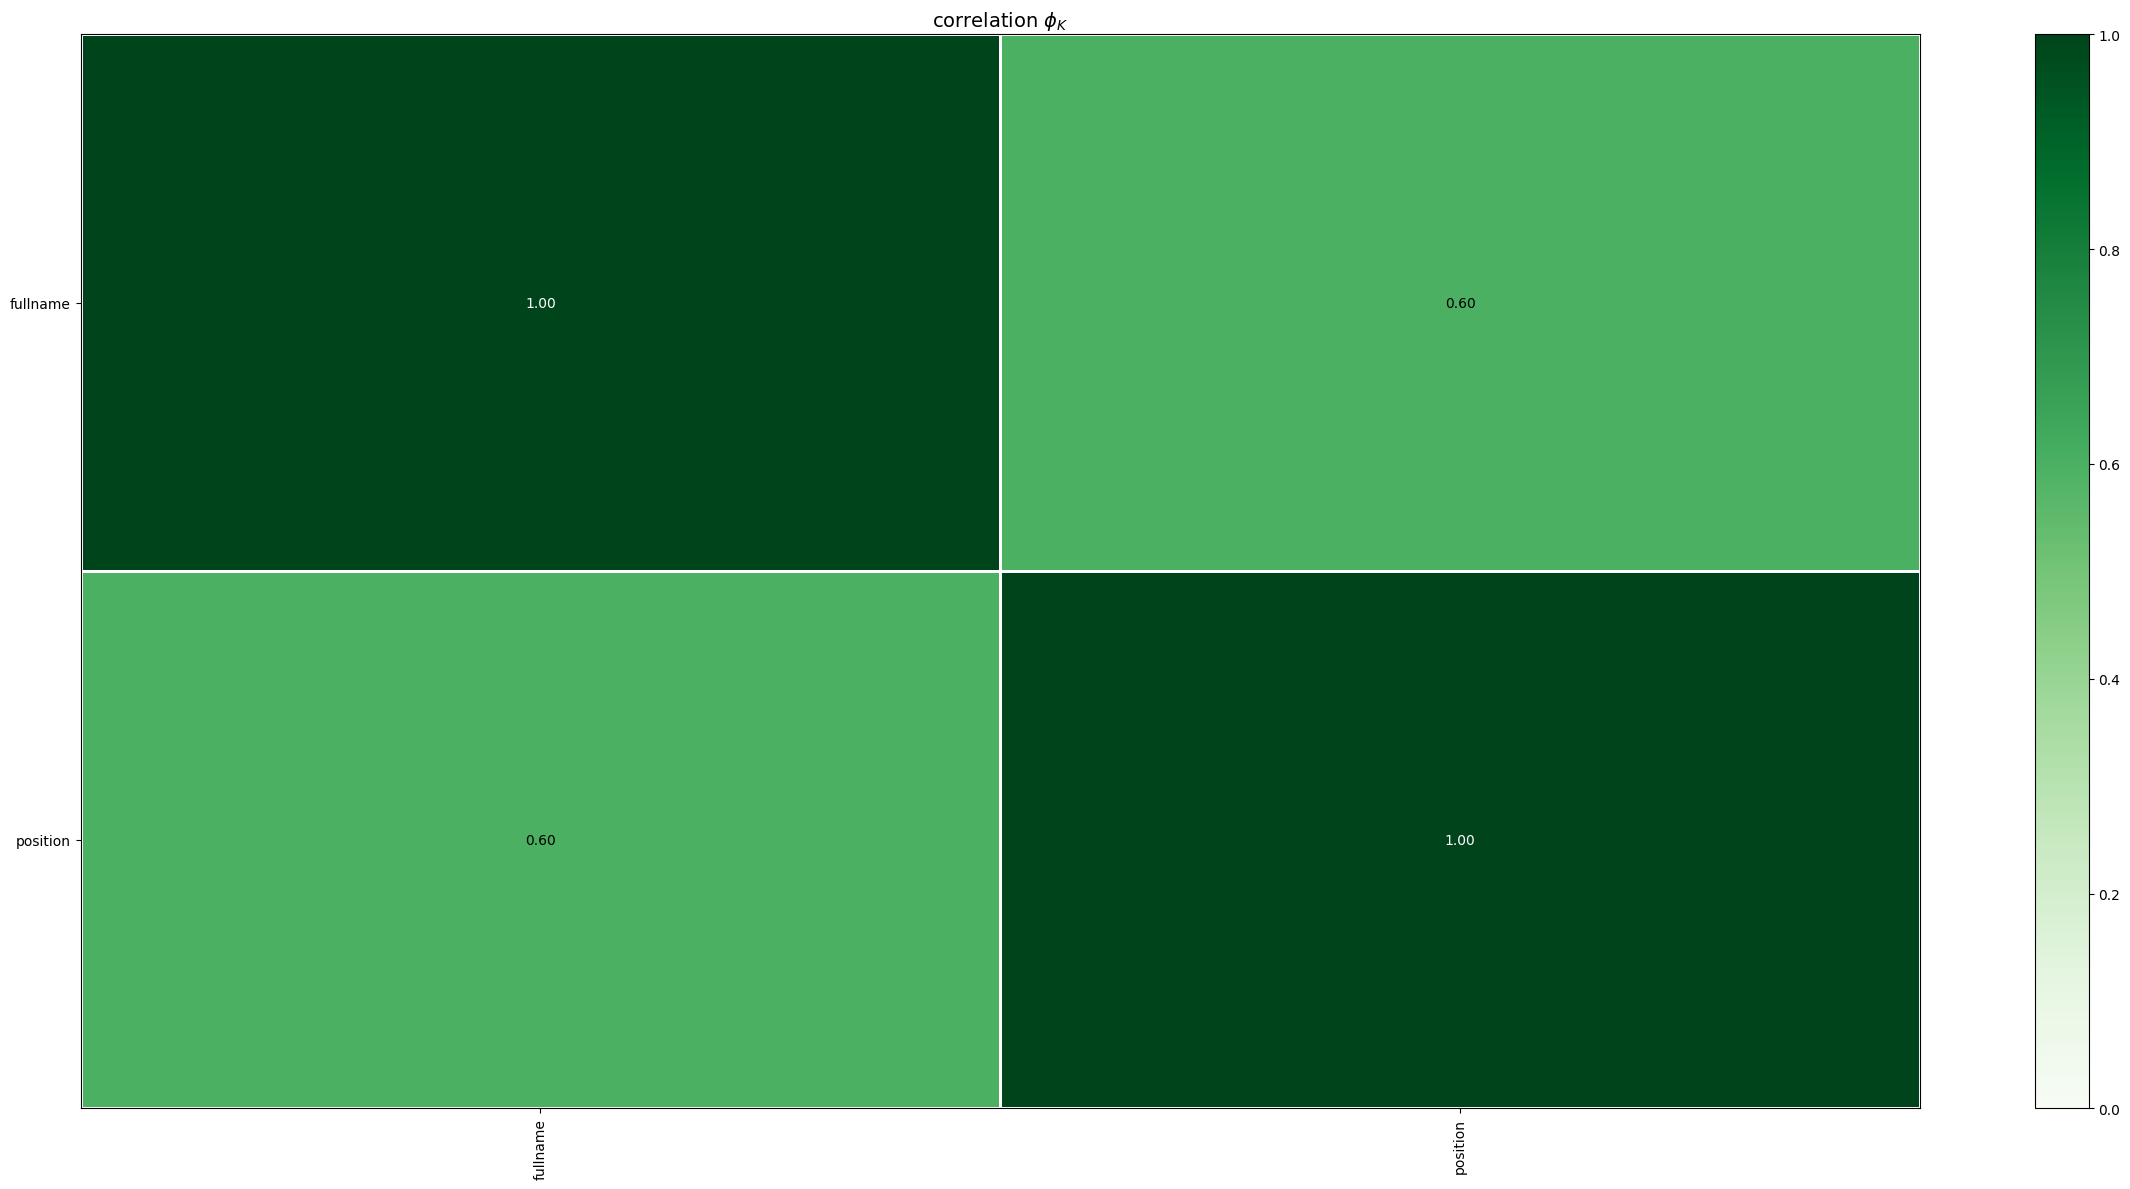

In [69]:
s_phik = see.phik_matrix()

plot_correlation_matrix(s_phik.values, 
                        x_labels=s_phik.columns, 
                        y_labels=s_phik.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
#                         fontsize_factor=1.5, 
                        figsize=(24, 12))
plt.tight_layout()

## Phik-k correlation

In [85]:
origin_cols = [
    'InitialFee',
    'sex',
    'citizenshipid',
    'martialid',
    'dependents',
    'typeemployerid',
    'sitename',
    'DOC',
    'averagemonthlyincome',
    'OccupationAreaId',
    'EmploymentType',
    'loan_amount',
    'age',
    'month',
    'day',
    'weekday',
    'seconds',
    'year',
    'nameto',
    '30_2mob',
    '60_6mob'
]

nbki_cols = [
    'Total_overdue_amount',
    'Total_installment_amount',
    'Total_inquiries',
    'Recent_inquiries',
    'Nb_delays_5_30_2y',
    'Nb_delays_90_2y',
    'Days_since_last_credit',
    'Own_active_accounts_nb',
    'Max_overdue',
    'RCC_credit_limit',
    'Nb_active_mortgages',
    'Total_consumer_credit',
    # '30_2mob',s
    '60_6mob'
]

eq_cols = [
    'Total_accounts_ever',
    'Total_active_accounts_eq',
    'Total_credit_limit_active_eq',
    'Total_outstanding_amount_eq',
    'Total_overdue_amount_eq',
    'Total_pay_amount',
    'Total_pay_amount_non_card',
    'Nb_delays_5_30_ever_eq',
    'Nb_delays_30_60_ever_eq',
    'Nb_delays_60_90_ever_eq',
    'Nb_delays_90plus_ever_eq',
    'Nb_delays_5_30_2y_eq',
    'Nb_delays_30_60_2y_eq',
    'Nb_delays_60_90_2y_eq',
    'Nb_delays_90plus_2y_eq',
    'Max_overdue_eq',
    'Nb_microcredits_ever',
    'CH_length_eq',
    'Nb_active_microcredits_eq',
    'S_hare_active_credit',
    'S_hare_micro',
    '60_6mob',
#     '30_2mob',
]

mts_cols = [
    'ALLCLCValueId',
    'BLOCKCNTValueId',
    'BLOCKDURValueId',
    'INTEGRALSCOREValueId',
    'LIFETIMEBINValueId',
    'PAYMAXValueId',
    '60_6mob',
#     '30_2mob',
]

In [84]:
origin_interval_cols = [
    'day',
    'seconds',
    'age',
    'dependents',
    'averagemonthlyincome',
    'loan_amount',
    'InitialFee',
    'creditperiod',
    'year',
]

nbki_interval_cols = [
    'Total_overdue_amount',
    'Total_installment_amount',
    'Total_inquiries',
    'Recent_inquiries',
    'Nb_delays_5_30_2y',
    'Nb_delays_90_2y',
    'Days_since_last_credit',
    'Own_active_accounts_nb',
    'Max_overdue',
    'RCC_credit_limit',
    'Nb_active_mortgages',
    'Total_consumer_credit',
]


# eq_interval_cols =[
#     'CH_length_eq',
#     'S_hare_micro',
#     'S_hare_active_credit',
# ]

mts_interval_cols = [
    'ALLCLCValueId',
    'BLOCKCNTValueId',
    'BLOCKDURValueId',
    'INTEGRALSCOREValueId',
    'LIFETIMEBINValueId',
    'PAYMAXValueId',
]

### origin

- month high corr with DOC, sitename, nameto, domen
- creditperiod with sitename & nameto (domen & category good)
- employementtype & positionlevel 65% (оставляем первый, но надо собрать в группы данные?)
- othercredits - DOC, sitename, nameto
- DOC точно дропаем
- domen - sitename, nameto

/var/folders/px/3klfkkvx3tncjgwrqb5l4jhc0000gp/T/ipykernel_58661/2090452021.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


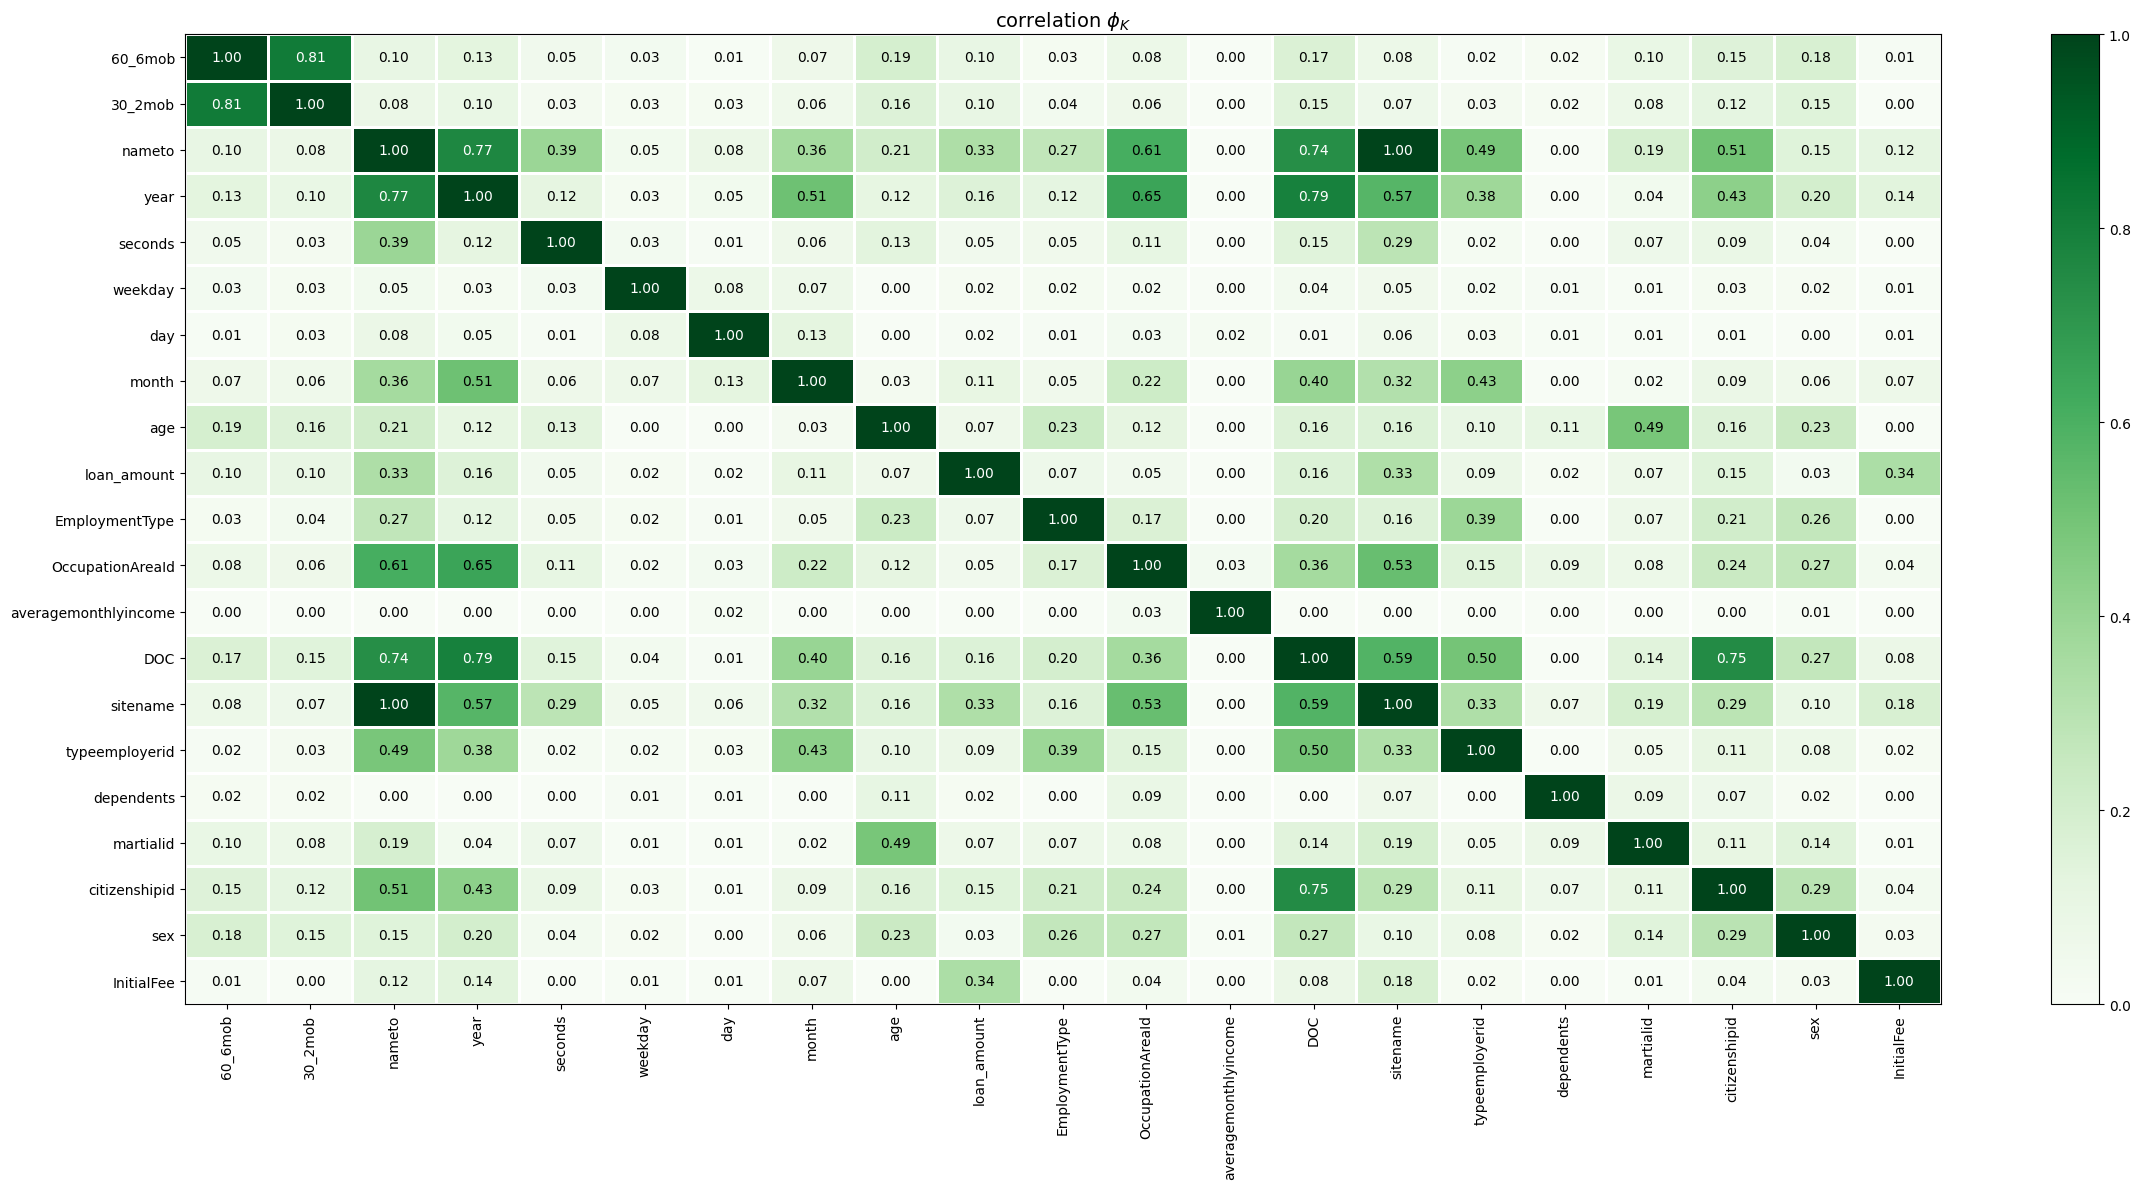

In [82]:
origin_phik = data[origin_cols].phik_matrix(interval_cols = origin_interval_cols)

plot_correlation_matrix(origin_phik.values, 
                        x_labels=origin_phik.columns, 
                        y_labels=origin_phik.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
#                         fontsize_factor=1.5, 
                        figsize=(24, 12))
plt.tight_layout()

### nbki 

/var/folders/px/3klfkkvx3tncjgwrqb5l4jhc0000gp/T/ipykernel_58661/3284356169.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


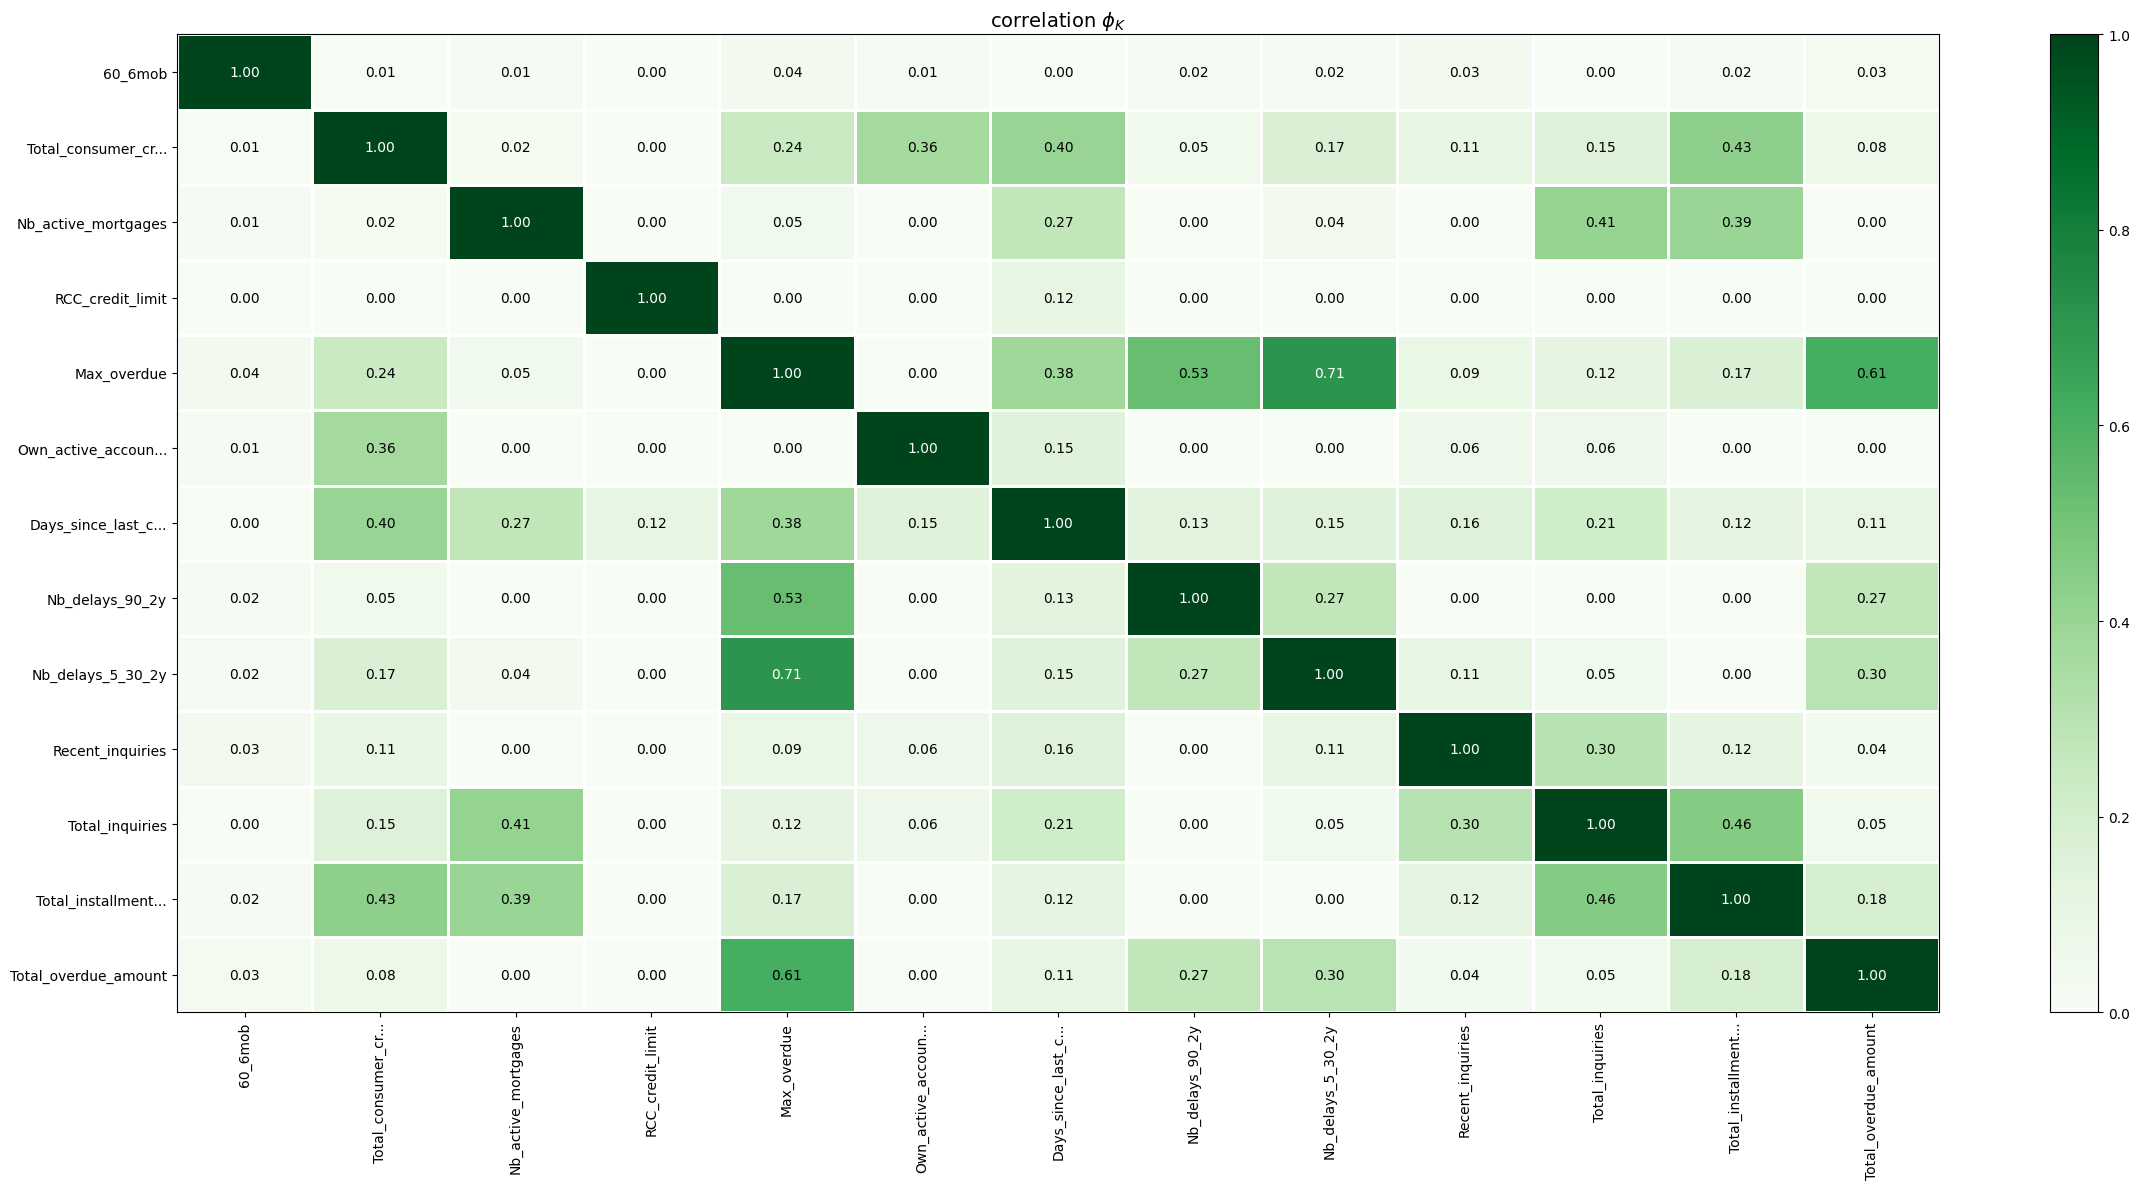

In [86]:
nbki_phik = data[nbki_cols].phik_matrix(interval_cols = nbki_interval_cols)

plot_correlation_matrix(nbki_phik.values, 
                        x_labels=nbki_phik.columns, 
                        y_labels=nbki_phik.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
#                         fontsize_factor=1.5, 
                        figsize=(24, 12))
plt.tight_layout()

### equvifax

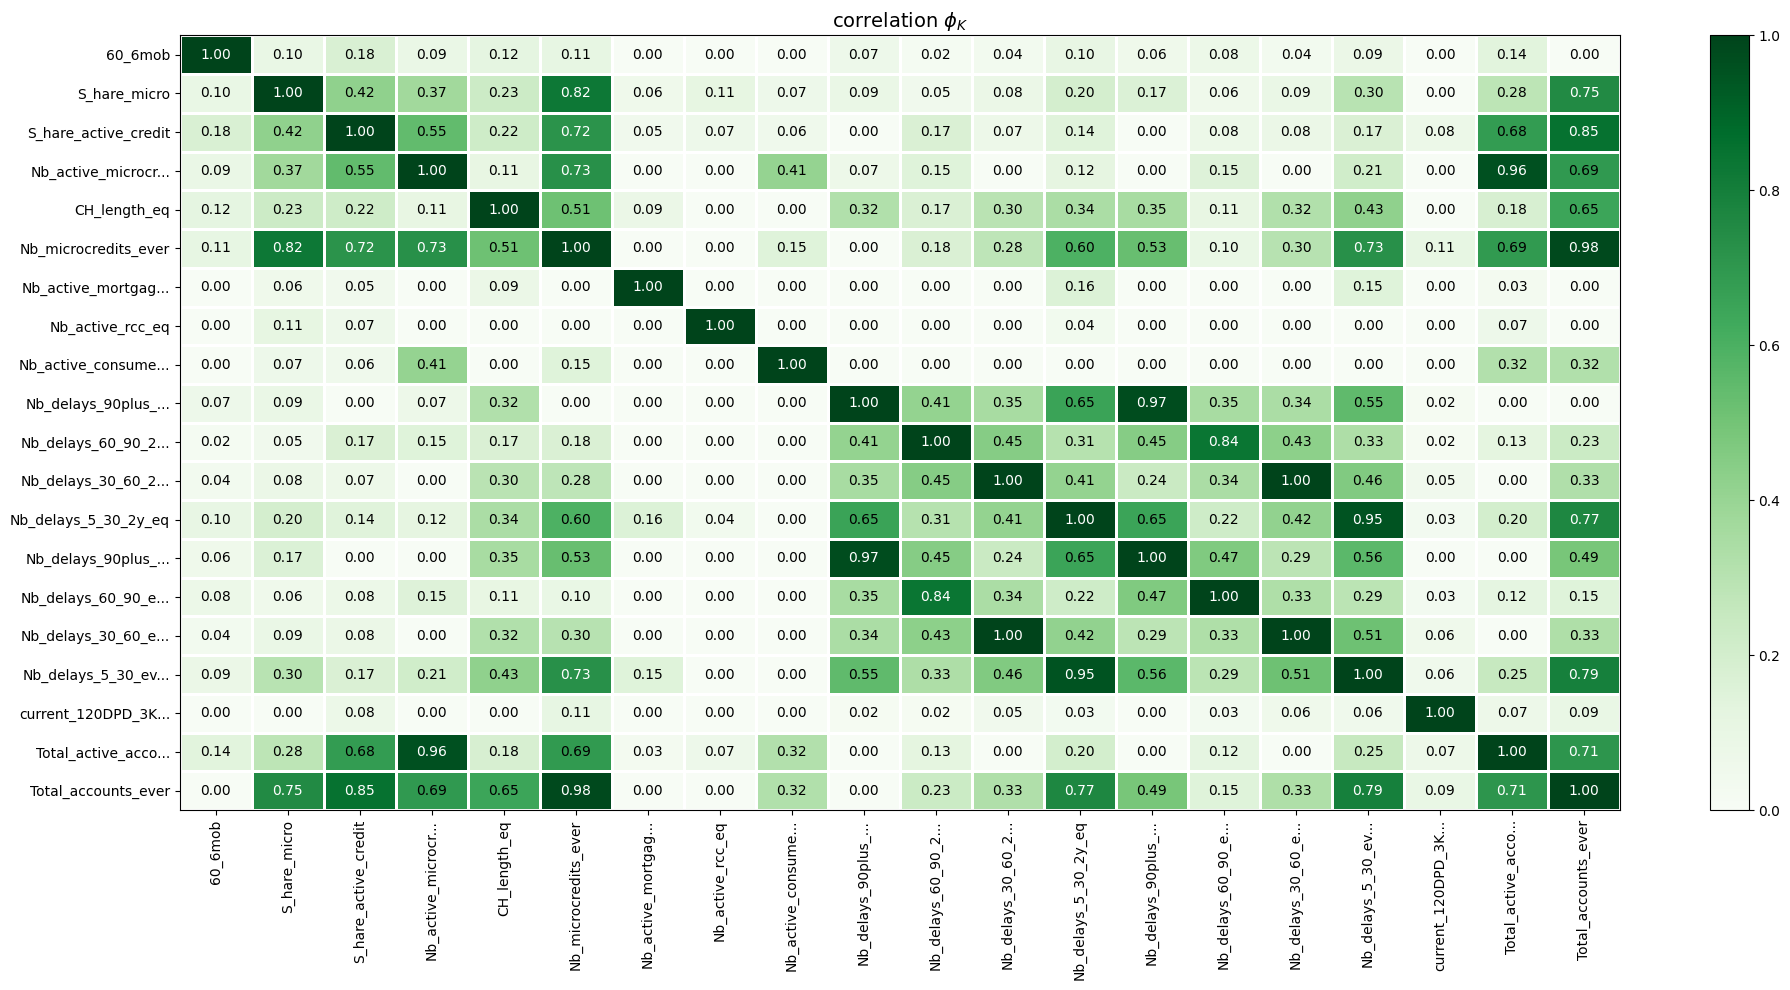

In [166]:
eq_phik = data[eq_cols].phik_matrix(interval_cols = eq_interval_cols)

plot_correlation_matrix(eq_phik.values, 
                        x_labels=eq_phik.columns, 
                        y_labels=eq_phik.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
#                         fontsize_factor=1.5, 
                        figsize=(20, 10))
plt.tight_layout()

### mts

/var/folders/px/3klfkkvx3tncjgwrqb5l4jhc0000gp/T/ipykernel_7353/3339143771.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


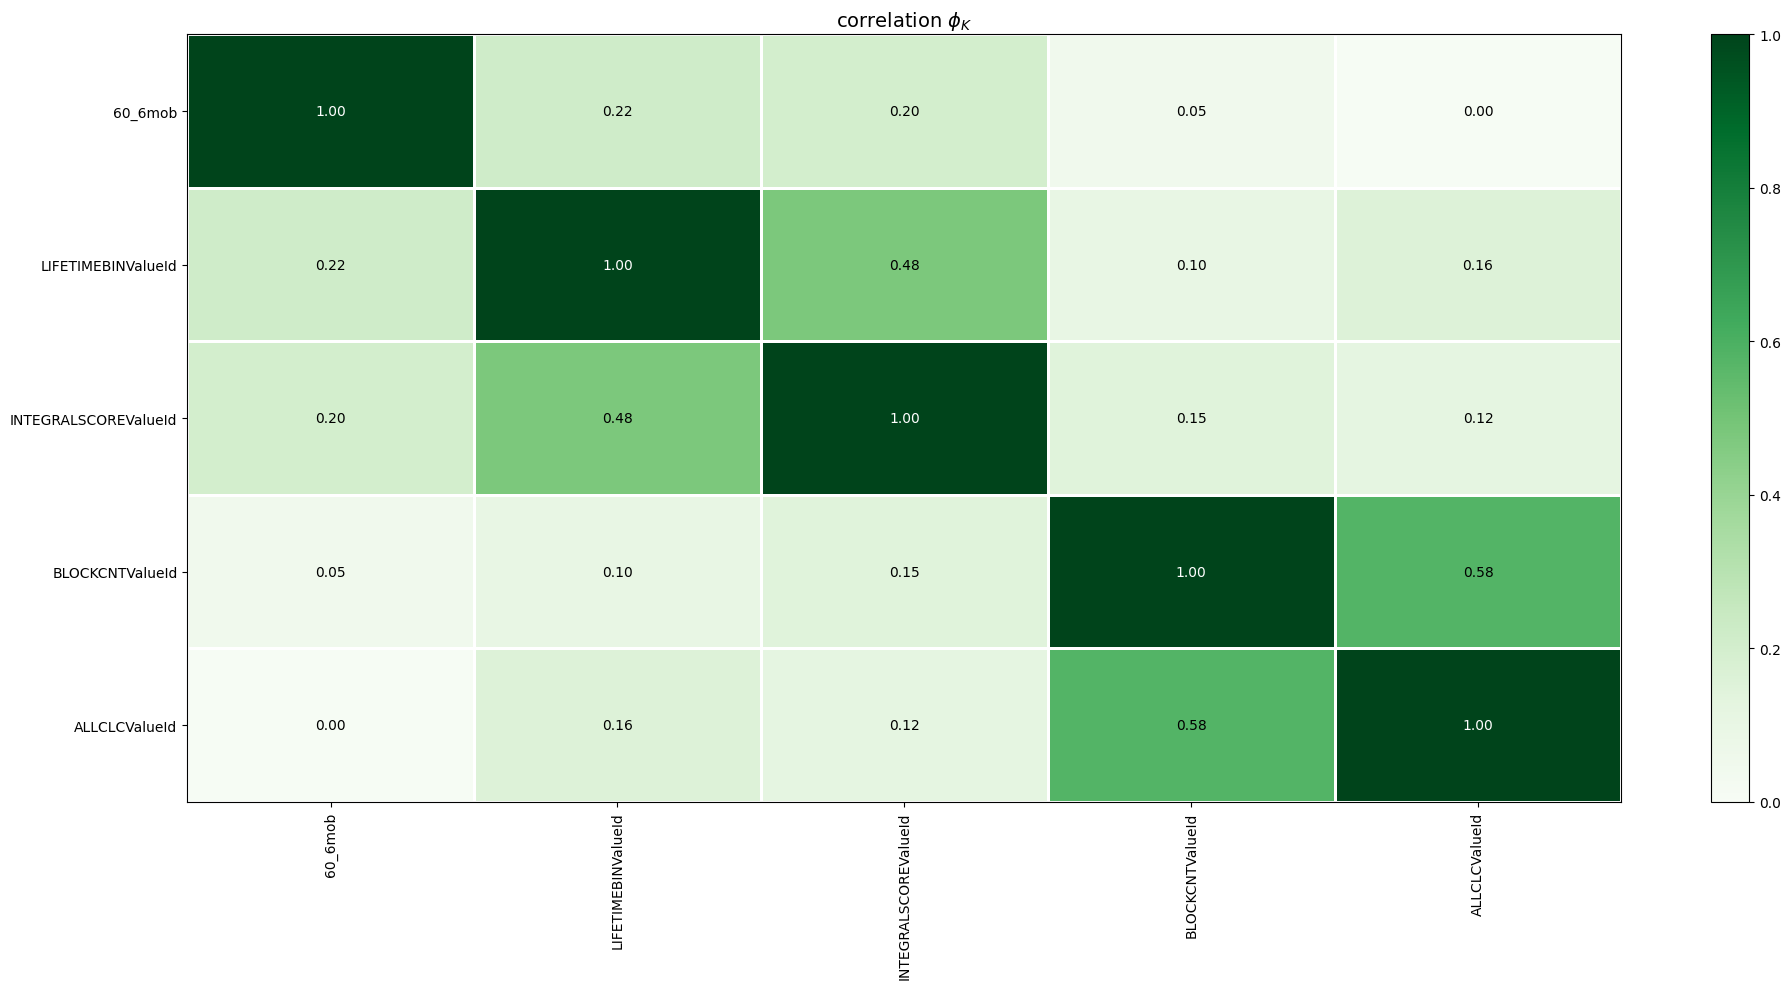

In [91]:
mts_phik = data[mts_cols].drop(columns=['BLOCKDURValueId', 'PAYMAXValueId']).phik_matrix(interval_cols = mts_interval_cols)

plot_correlation_matrix(mts_phik.values, 
                        x_labels=mts_phik.columns, 
                        y_labels=mts_phik.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
#                         fontsize_factor=1.5, 
                        figsize=(20, 10))
plt.tight_layout()

In [77]:
mts_2 = [
    'ALLCLCValueId',
    'BLOCKCNTValueId',
    'INTEGRALSCOREValueId',
    'LIFETIMEBINValueId',
    '60_6mob'
]

## All columns

In [78]:
all_cols = dropped_data.columns.to_list()

In [79]:
all_cols.extend(v_2.columns.to_list())

In [80]:
all_cols.extend(mts_2)

In [81]:
all_cols = pd.Series(all_cols).drop_duplicates().tolist()

In [89]:
all_data = pd.merge(data[all_cols], see, left_index=True, right_index=True)

In [90]:
all_interval_cols = [
    'day',
    'seconds',
    'age',
    'dependents',
    'averagemonthlyincome',
    'InitialFee',
    'Total_negative_accounts' ,
    'Total_overdue_amount',  
    'Total_inquiries' ,
    'Recent_inquiries' , 
    'Nb_delays_5_30_2y', 
    'Nb_delays_90_2y' , 
    'Days_since_last_credit' ,
    'Total_mortgages' , 
    'Total_microcredits' , 
    'Total_consumer_credit' ,
    'Total_rcc' , 
    'ALLCLCValueId',
    'BLOCKCNTValueId',
    'INTEGRALSCOREValueId',
    'LIFETIMEBINValueId',
]

In [93]:
data['fullname'].isna().sum()

60

In [95]:
all_data.groupby(['position', 'sex'])['sex'].count()

position  sex
0.0       1.0     104
          2.0      99
1.0       1.0     290
          2.0      45
2.0       1.0    1956
                 ... 
31.0      1.0      24
          2.0     149
32.0      1.0     304
33.0      1.0    3551
          2.0    1418
Name: sex, Length: 61, dtype: int64

/var/folders/px/3klfkkvx3tncjgwrqb5l4jhc0000gp/T/ipykernel_4086/347928436.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


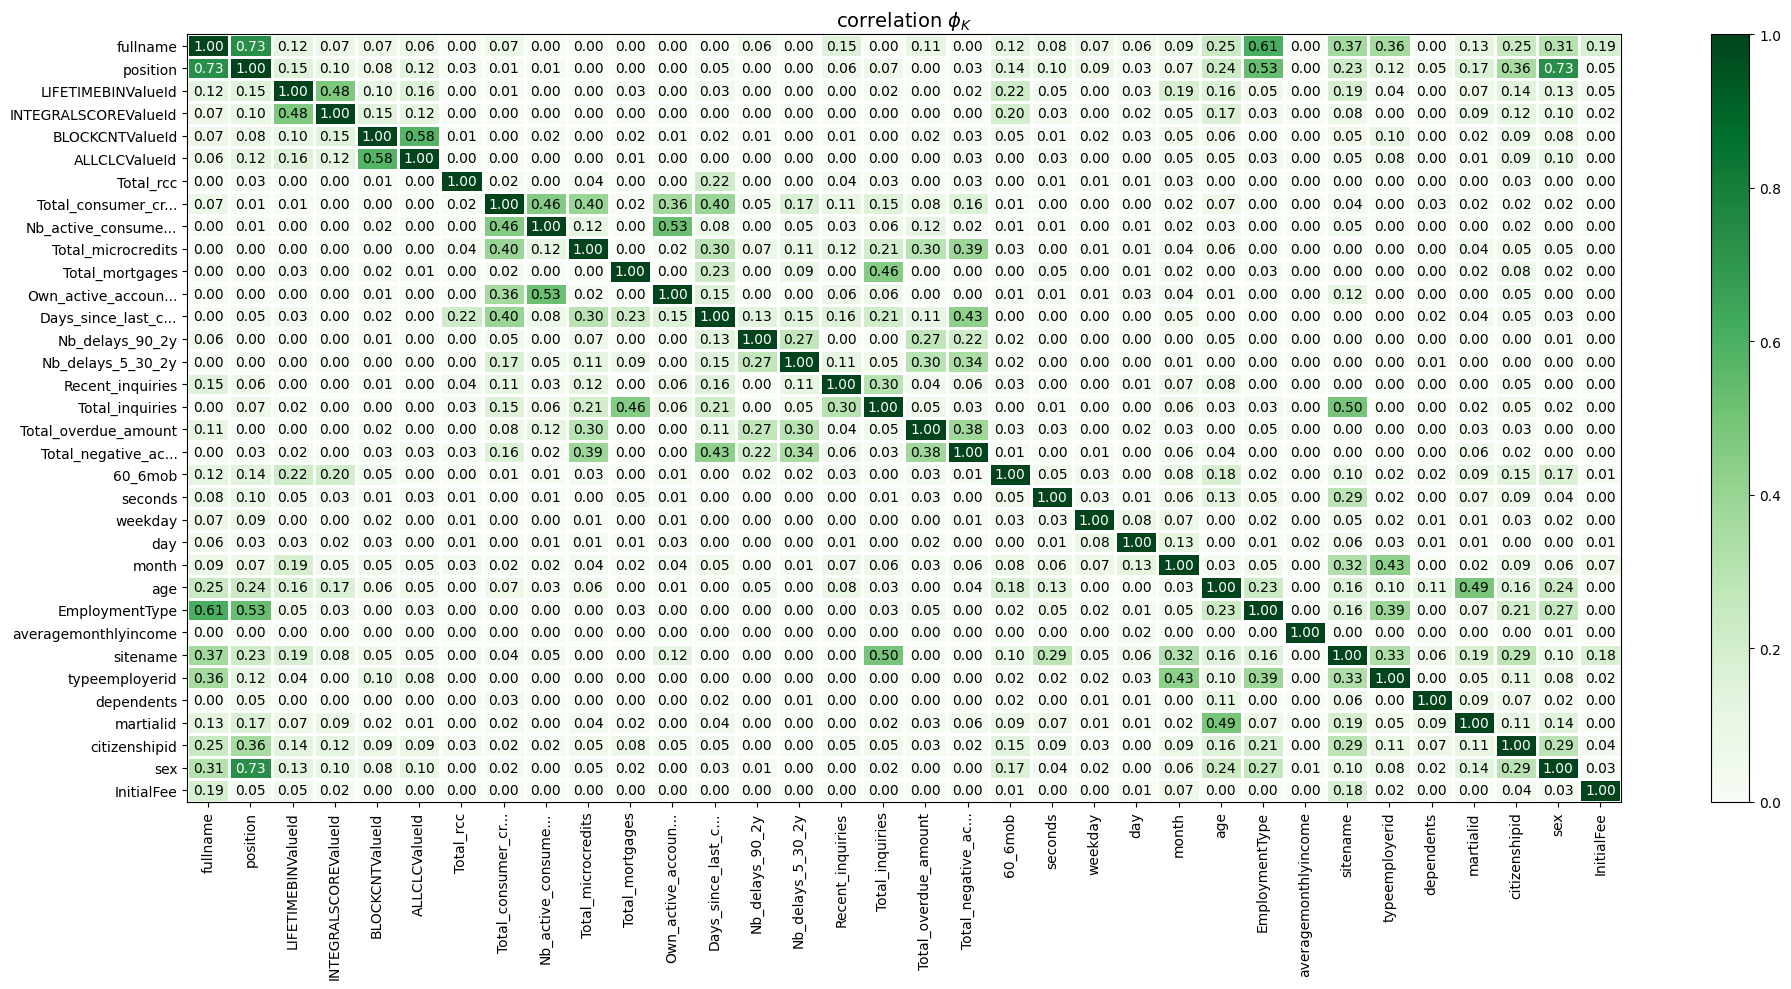

In [91]:
all_phik = all_data.phik_matrix(interval_cols = all_interval_cols)

plot_correlation_matrix(all_phik.values, 
                        x_labels=all_phik.columns, 
                        y_labels=all_phik.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
#                         fontsize_factor=1.5, 
                        figsize=(20, 10))
plt.tight_layout()

## Корреляция

In [123]:
all_corr = data[all_interval_cols]
all_corr_float = all_corr.astype('float')

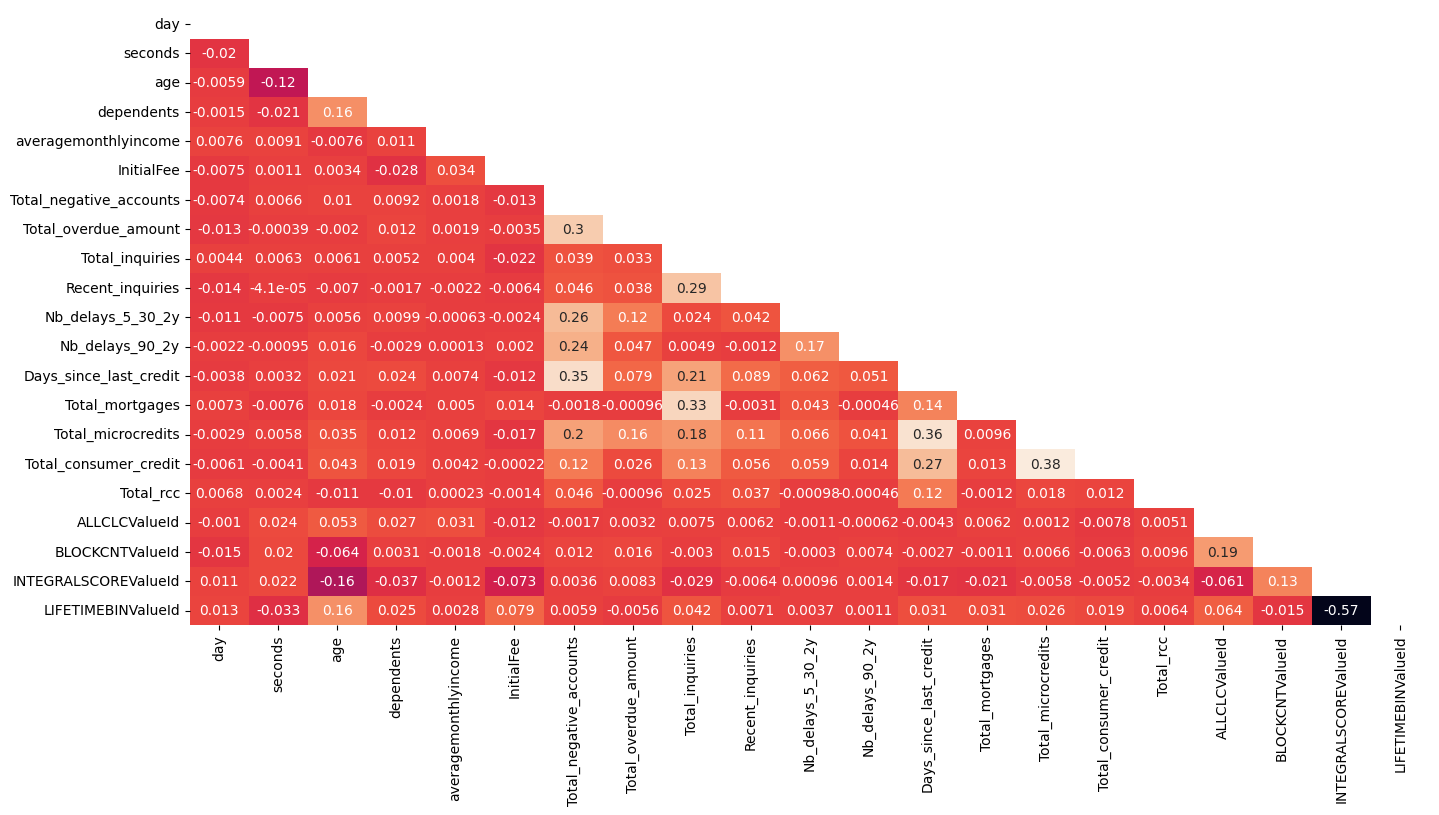

In [140]:
# построим график корреляции
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(
    all_corr.corr(method='pearson'),
    mask=np.triu(np.ones_like(all_corr_float.corr(), dtype=bool)),
    annot=True,
    cbar=False,
)
plt.show()

In [9]:
 def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))

    return pairs_to_drop


def get_top_abs_correlations(df, n=10):
    au_corr = df.corr(method='spearman').abs().unstack().sort_values(ascending=False)
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)

    return au_corr[0: n]

In [45]:
# посмотрим на корреляцию в числовом виде и выведем Топ 20 скореллированных пар
print('Top Absolute Correlations')
print(get_top_abs_correlations(data_corr, 20))

Top Absolute Correlations
Total_pay_amount              Total_pay_amount_non_card        0.999548
Total_overdue_amount_eq       Max_overdue_eq                   0.999409
Total_accounts                Days_since_last_credit           0.999397
                              Total_credit_limit               0.995200
Total_credit_limit            Days_since_last_credit           0.994191
Total_active_accounts_eq      Total_credit_limit_active_eq     0.964782
Total_credit_limit_active_eq  Total_outstanding_amount_eq      0.964182
Total_active_accounts         Total_outstanding_amount         0.959649
AmountPurchaseOriginal        Loan amount                      0.953643
Nb_delays_60_90_ever_eq       Nb_delays_60_90_2y_eq            0.942837
Total_outstanding_amount      Total_installment_amount         0.936369
Total_outstanding_amount_eq   Total_pay_amount                 0.935245
                              Total_pay_amount_non_card        0.934463
Total_active_accounts_eq      Total_ou

In [14]:
cols = [
    'Total_credit_limit',
    'Total_accounts',
    'Days_since_last_credit',
    'Total_pay_amount_non_card',
    'Total_pay_amount',
    'Max_overdue_eq',
    'Total_overdue_amount_eq',
]

In [15]:
ranked_data = data[cols].copy()

In [16]:
ranked_data

,Total_credit_limit,Total_accounts,Days_since_last_credit,Total_pay_amount_non_card,Total_pay_amount,Max_overdue_eq,Total_overdue_amount_eq
AppId,,,,,,,
637036,0.0,0.0,0.0,NaN,NaN,NaN,NaN
710271,NaN,NaN,NaN,NaN,NaN,NaN,NaN
711522,0.0,0.0,0.0,NaN,NaN,NaN,NaN
716301,0.0,0.0,0.0,NaN,NaN,NaN,NaN
726098,0.0,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2062191,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2062441,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2062492,NaN,NaN,NaN,0.0,0.0,0.0,0.0


In [17]:
for i in cols:
    ranked_data[i] = ranked_data[i].rank(method='average')

In [18]:
ranked_data

,Total_credit_limit,Total_accounts,Days_since_last_credit,Total_pay_amount_non_card,Total_pay_amount,Max_overdue_eq,Total_overdue_amount_eq
AppId,,,,,,,
637036,9091.0,9087.5,9087.5,NaN,NaN,NaN,NaN
710271,NaN,NaN,NaN,NaN,NaN,NaN,NaN
711522,9091.0,9087.5,9087.5,NaN,NaN,NaN,NaN
716301,9091.0,9087.5,9087.5,NaN,NaN,NaN,NaN
726098,9091.0,9087.5,9087.5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2062191,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2062441,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2062492,NaN,NaN,NaN,905.5,904.5,1436.0,1436.0


In [19]:
ranked_data.corr()

,Total_credit_limit,Total_accounts,Days_since_last_credit,Total_pay_amount_non_card,Total_pay_amount,Max_overdue_eq,Total_overdue_amount_eq
Total_credit_limit,1.000000,0.995200,0.994191,0.132175,0.133467,0.000319,-0.001083
Total_accounts,0.995200,1.000000,0.999397,0.131129,0.132422,0.000289,-0.001130
Days_since_last_credit,0.994191,0.999397,1.000000,0.125751,0.127092,0.000621,-0.000855
Total_pay_amount_non_card,0.132175,0.131129,0.125751,1.000000,0.999548,0.102052,0.102055
Total_pay_amount,0.133467,0.132422,0.127092,0.999548,1.000000,0.101901,0.101903
Max_overdue_eq,0.000319,0.000289,0.000621,0.102052,0.101901,1.000000,0.999409
Total_overdue_amount_eq,-0.001083,-0.001130,-0.000855,0.102055,0.101903,0.999409,1.000000


In [20]:
data[cols].corr(method='spearman')

,Total_credit_limit,Total_accounts,Days_since_last_credit,Total_pay_amount_non_card,Total_pay_amount,Max_overdue_eq,Total_overdue_amount_eq
Total_credit_limit,1.000000,0.995200,0.994191,0.141738,0.142886,-0.000048,-0.001602
Total_accounts,0.995200,1.000000,0.999397,0.138867,0.140020,0.000038,-0.001571
Days_since_last_credit,0.994191,0.999397,1.000000,0.125774,0.127025,0.000907,-0.000847
Total_pay_amount_non_card,0.141738,0.138867,0.125774,1.000000,0.999548,0.102052,0.102055
Total_pay_amount,0.142886,0.140020,0.127025,0.999548,1.000000,0.101901,0.101903
Max_overdue_eq,-0.000048,0.000038,0.000907,0.102052,0.101901,1.000000,0.999409
Total_overdue_amount_eq,-0.001602,-0.001571,-0.000847,0.102055,0.101903,0.999409,1.000000


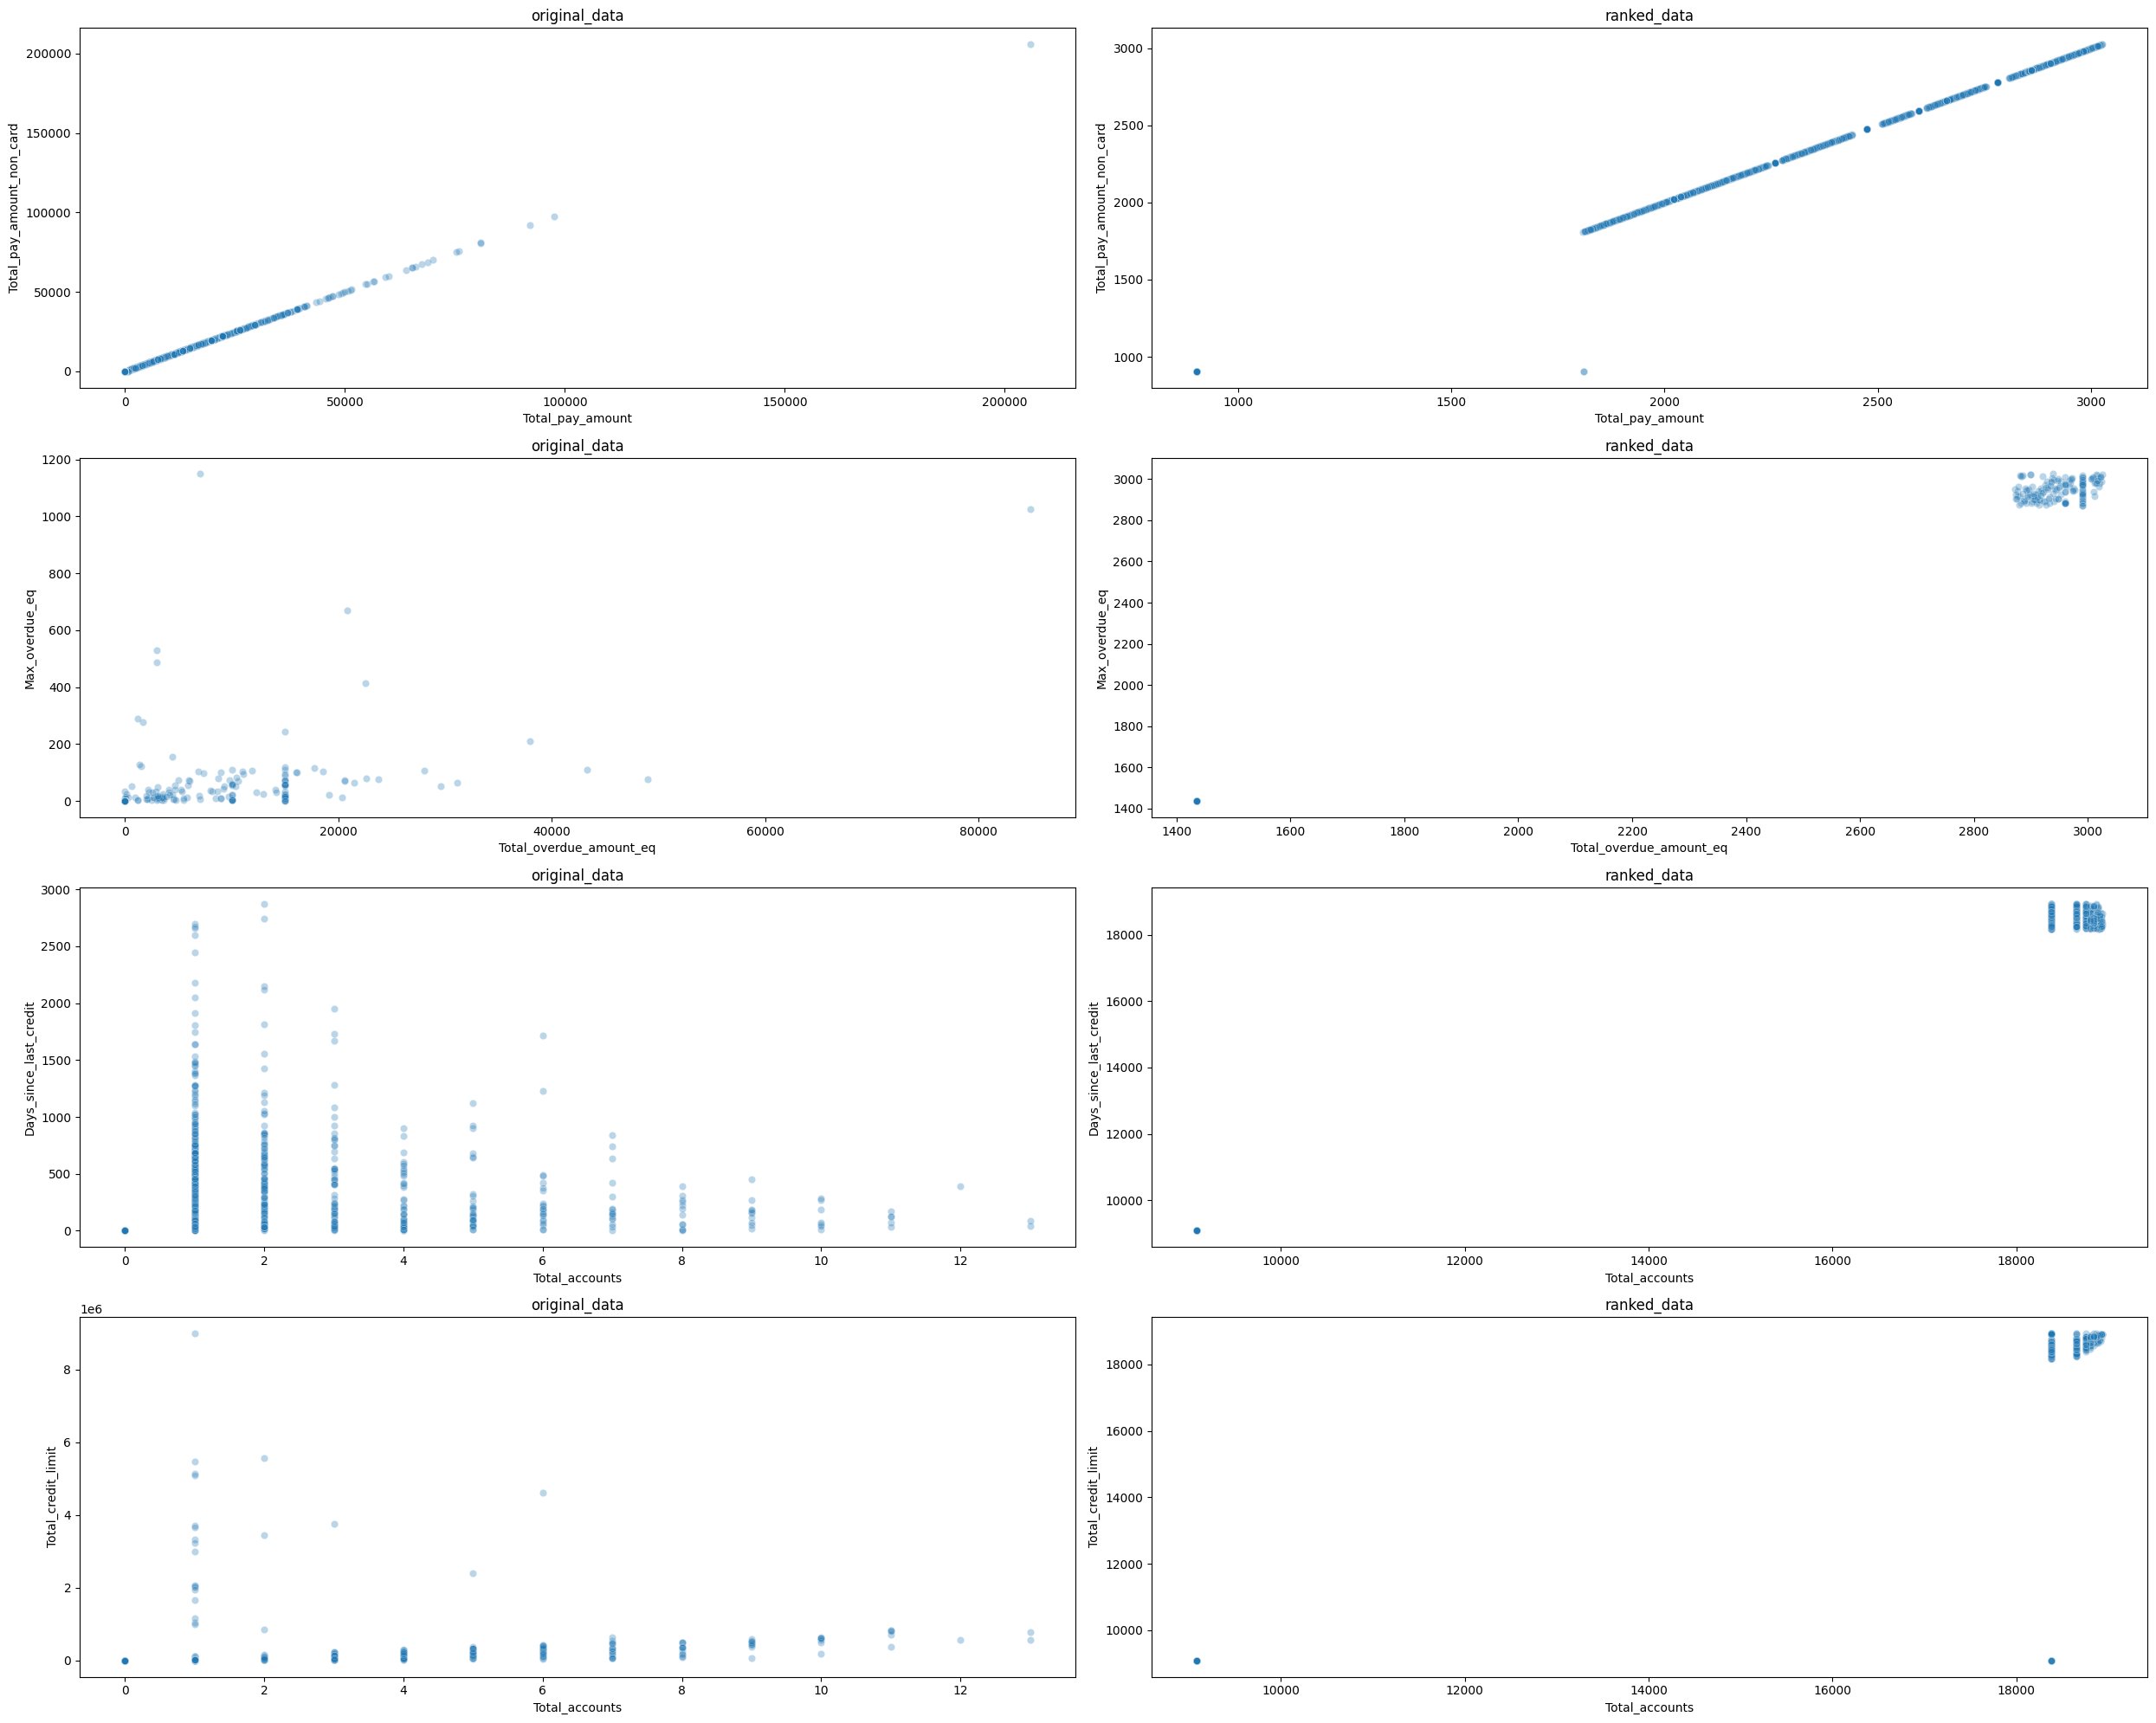

In [44]:
fig, axes = plt.subplots(4,2, figsize=(25,20))
#1
sns.scatterplot(
    data=data,
    x='Total_pay_amount',
    y='Total_pay_amount_non_card',
    alpha=0.3,
    ax=axes[0,0]
)
axes[0, 0].set( title='original_data', xlabel='Total_pay_amount', ylabel='Total_pay_amount_non_card')

sns.scatterplot(
    data=ranked_data,
    x='Total_pay_amount',
    y='Total_pay_amount_non_card',
    alpha=0.3,
    ax=axes[0,1],
)
axes[0, 1].set(title='ranked_data', xlabel='Total_pay_amount', ylabel='Total_pay_amount_non_card')

#2
sns.scatterplot(
    data=data,
    x='Total_overdue_amount_eq',
    y='Max_overdue_eq',
    alpha=0.3,
    ax=axes[1,0]
)
axes[1, 0].set(title='original_data', xlabel='Total_overdue_amount_eq', ylabel='Max_overdue_eq')

sns.scatterplot(
    data=ranked_data,
    x='Total_overdue_amount_eq',
    y='Max_overdue_eq',
    alpha=0.3,
    ax=axes[1,1],
)
axes[1, 1].set(title='ranked_data', xlabel='Total_overdue_amount_eq',ylabel='Max_overdue_eq')

#3
sns.scatterplot(
    data=data,
    x='Total_accounts',
    y='Days_since_last_credit',
    alpha=0.3,
    ax=axes[2,0]
)
axes[2, 0].set(title='original_data', xlabel='Total_accounts', ylabel='Days_since_last_credit')

sns.scatterplot(
    data=ranked_data,
    x='Total_accounts',
    y='Days_since_last_credit',
    alpha=0.3,
    ax=axes[2,1],
)
axes[2, 1].set(title='ranked_data', xlabel='Total_accounts',ylabel='Days_since_last_credit')

#4
sns.scatterplot(
    data=data,
    x='Total_accounts',
    y='Total_credit_limit',
    alpha=0.3,
    ax=axes[3,0]
)
axes[3, 0].set(title='original_data', xlabel='Total_accounts', ylabel='Total_credit_limit')

sns.scatterplot(
    data=ranked_data,
    x='Total_accounts',
    y='Total_credit_limit',
    alpha=0.3,
    ax=axes[3,1],
)
axes[3, 1].set(title='ranked_data', xlabel='Total_accounts',ylabel='Total_credit_limit')

fig.tight_layout()
plt.show()

## Выгрузка датасета

In [ ]:
data.to_csv(utils.constants.CL_PREPARED_DATA_PATH)